In [2]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

from statsmodels.stats.multicomp import pairwise_tukeyhsd

import re
import nltk


from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from datetime import datetime

import xgboost as xgb
from xgboost import XGBRegressor

In [3]:
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)

# How a Data Scientist buys a car? Polish edition.

Some time ago I red an article "How a Data Scientist buys a car" by Will Casey published on towardsdatascience.com (link). I decided to create a Polish edition using data from polish car auction website otomoto.pl. I had a couple of goals before writing the artice. Firstly, I wanted to try some web scraping which I've never done before. Secondly, I wanted to create a data science project with very practical practical application from start to finish. Thirdly, the project is a way for me to  keep my Python skills up to dae. Lastly, this is probably the first article on my blog which I've wanted to start for quite some time.

## The crucial part of every data science project - getting data

I don't think that there is an open database with prices of polish cars so I had to scrape my own data. I've decided to take an approach which would allow me to get data relatively easily and quickly. After quick research it turned out that ParseHub is the leading software for webscrpaing and has some potential even with the free version. This is what I'll use in the project.
I hope it will be a 20-80 approach with 20% of effort and 80% of results.
ParseHub has some limitations in the free version, especially concerning the limit of number of pages. Because of this I had to heavily lower the level of detail in the data. I could not (or didn't know how to) open every offer and grab all the data I wanted using the free version.
Using a custom solution created in Selenium or another tool could bring some benefits to the level of detail in the data but would definitiely be much more time consuming than using an existing solution like ParseHub. This is definitiely on my to-do list for the future.

The webscraping process starts here: https://www.otomoto.pl/osobowe/uzywane/?search%5Border%5D=created_at_first%3Adesc&search%5Bbrand_program_id%5D%5B0%5D=&search%5Bcountry%5D=&l=1
At this point I've made some crucial decisions:
- I focus on used cars as they represent the majority of offers on OtoMoto (at the time of writing this article out of 211k total offers, 188k are used cars and the feature if the car is used or new is not easy to scrape),
- I select only personal cars to lower the variety of the dataset but also because personal cars is where most of my interest lies,
- I sort the results by the newest offer.

Due to constrained number of pages in the free version of ParseHub I was able to scrape only a limited number of features:
- price,
- title,
- subtitle,
- mileage,
- year the car was produced,
- capacity of the engine,
- type of the engine,
- city where the car is,
- province where the car is,
- an indicator whether the offer has been marked as negotiable and/or if it includes VAT.

In a single run ParseHub is able to scrape around 150 pages which means around 4.5 thousand offers each run. I ran the ParseHub project once every few days more or less regularly over the last 3 months. Each run creates a new csv file. I expect to have many duplicate offers using this method.

## The beginning of the analysis

Let's start by importing the Car class. I've created the custom class for this article but my goal was to create solutions that can be easily transfered to a generic Python class which would make basic analytics as easy as possible. Such class is on my to-do list. For now, you can see the code of the class and a few custom functions here (link).

In [9]:
import Car
data = Car.Car(path = 'data/',
                     read_from_path = 'yes',                     
                    
                     dependent_variable = 'price',
                     categorical_variables = ['engine_type', 'city', 'province', 'negotiable'],
                     numeric_variables = ['price', 'mileage_km', 'engine_cm3', 'year'])

There are two options to supply the Car class with data. The first one is to pass a Pandas dataframe or the second one is to import all csv files from a path. I'm using the second option because of the way I've decided to get data for the project.
The other parameters passed to the class indicate what is the dependent variable and which variables are categorical and which are numerical.

The init method of the Car class does some basic preprocessing:
- deletes duplicates,
- removes rows where engine type, city or province is missing. This is done due to higher number of missing values in this column and scraping errors what can influence the data quality,
- removes some unncessary strings and brackets from some columns,
- adds an ID column,
- adds a column which is a concatenation of title and subtitle column,
- removes polish letters from the concatenation column, city and province columns.

Let's see the data after the class has been initialized.

In [4]:
data.data.head()

,ID,title,price,sub_title,mileage_km,year,engine_cm3,engine_type,city,province,negotiable,concat_title_subtitle
0,1,Mazda CX-3,69700,150KM 6AT 4x4 SkyPASSION (+ Biala skóra + Safe...,51015.0,2015,1998,Benzyna,katowice,slaskie,nan,mazda cx 3 150km 6at 4x4 skypassion biala s...
1,2,Peugeot Partner,19500,Opłacony~Dokumentacja Przebiegu,180000.0,2009,1600,Diesel,garbatka-letnisko,mazowieckie,Do negocjacji,peugeot partner oplacony dokumentacja przebiegu
2,3,Kia Sportage,26800,Opłacona~Napęd 4x4,165000.0,2009,2000,Benzyna,garbatka-letnisko,mazowieckie,Do negocjacji,kia sportage oplacona naped 4x4
3,4,Škoda Roomster,12900,Opłacona~Serwis ASO~Klimatronic~Grzane siedzenia,238000.0,2006,1600,Benzyna,garbatka-letnisko,mazowieckie,Do negocjacji,škoda roomster oplacona serwis aso klimatronic...
4,5,Opel Combo,14500,Klimatyzacja~Przebieg~Faktura~Polski Salon,136000.0,2009,1400,Benzyna,garbatka-letnisko,mazowieckie,"Do negocjacji, Faktura VAT",opel combo klimatyzacja przebieg faktura polsk...


We can see that all of the variables which should be scraped are in the dataset. But there is one obvious feature missing. The first one which comes to mind when we think about cars - a brand. Sadly, it could not be reliably scraped but it almost always appears in the title. Let's create a list with some brands.

In [5]:
brands = ['alfa', 'audi', 'bmw', 'chevrolet', 'chrysler',
          'citroen', 'dacia', 'daewoo', 'dodge', 'fiat',
          'ford', 'honda', 'hyundai', 'jaguar', 'jeep',
          'kia', 'rover', 'lexus', 'mazda', 'mercedes',
          'mitsubishi', 'nissan', 'opel', 'peugeot',
          'porsche', 'renault', 'seat', 'smart', 'subaru', 
          'suzuki', 'tesla', 'toyota', 'volkswagen',
          'volvo', 'skoda']

Now let's add dummy variables for every brand. It will be done using a custom method from the Car class which will look for the brand in the concat_title_subtitle column and if it finds the brand will set the dummy variable value to 1 and remove the brand from the column.

In [6]:
data.add_dummies2(brands) 

In [7]:
data.data.head()

,ID,title,price,sub_title,mileage_km,year,engine_cm3,engine_type,city,province,negotiable,concat_title_subtitle,alfa,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,dodge,fiat,ford,honda,hyundai,jaguar,jeep,kia,rover,lexus,mazda,mercedes,mitsubishi,nissan,opel,peugeot,porsche,renault,seat,smart,subaru,suzuki,tesla,toyota,volkswagen,volvo,skoda
0,1,Mazda CX-3,69700,150KM 6AT 4x4 SkyPASSION (+ Biala skóra + Safe...,51015.0,2015,1998,Benzyna,katowice,slaskie,nan,cx 3 150km 6at 4x4 skypassion biala skóra ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Peugeot Partner,19500,Opłacony~Dokumentacja Przebiegu,180000.0,2009,1600,Diesel,garbatka-letnisko,mazowieckie,Do negocjacji,partner oplacony dokumentacja przebiegu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,Kia Sportage,26800,Opłacona~Napęd 4x4,165000.0,2009,2000,Benzyna,garbatka-letnisko,mazowieckie,Do negocjacji,sportage oplacona naped 4x4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Škoda Roomster,12900,Opłacona~Serwis ASO~Klimatronic~Grzane siedzenia,238000.0,2006,1600,Benzyna,garbatka-letnisko,mazowieckie,Do negocjacji,škoda roomster oplacona serwis aso klimatronic...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,Opel Combo,14500,Klimatyzacja~Przebieg~Faktura~Polski Salon,136000.0,2009,1400,Benzyna,garbatka-letnisko,mazowieckie,"Do negocjacji, Faktura VAT",combo klimatyzacja przebieg faktura polski salon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Not only did the method add dummy variables for every brand and removed the brand name from the concat_title_subtitle column but also added all the brands to the list of categorical variables which will come into play in the next parts of the article.

## Removing outliers

Our final goal is to create a model which would predict accurately a price of an average car. This means that we are not interested in predicting a price of a Ferrari or other luxury cars so we can discard such cases from the training set to improve the predicting power for more modestly priced cars.
We need to carry out some basic analysis of the variables to make a decision what will be considered an outlier. Let's start with numerical variables.

### Numerical variables

Let's see some basic descriptive statistics.

In [9]:
data.describe()

,price,mileage_km,engine_cm3,year
count,97708.00,9.770800e+04,97708.00,97708.00
mean,36683.37,1.204644e+06,1851.29,2009.47
std,159727.78,3.199276e+08,644.00,6.03
min,250.00,0.000000e+00,400.00,1922.00
25%,12000.00,1.000000e+05,1490.00,2006.00
50%,22900.00,1.658000e+05,1798.00,2010.00
75%,41500.00,2.200000e+05,1997.00,2014.00
max,25829248.00,1.000000e+11,8300.00,2020.00


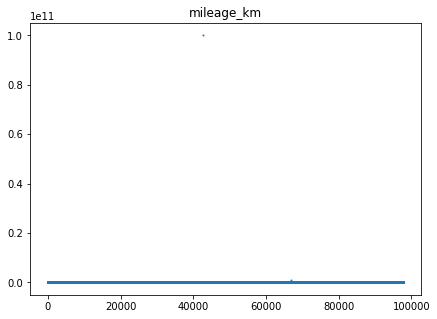

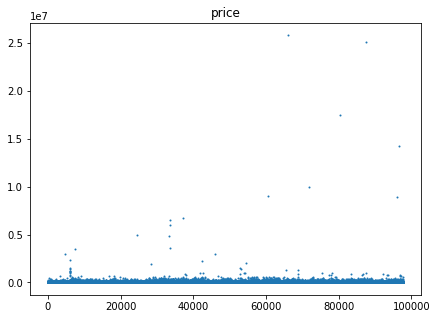

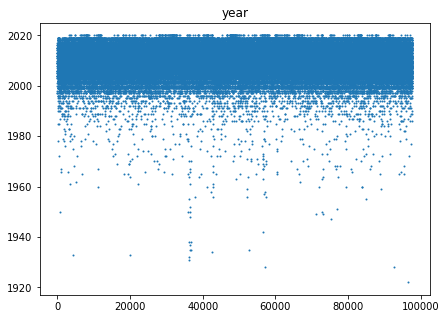

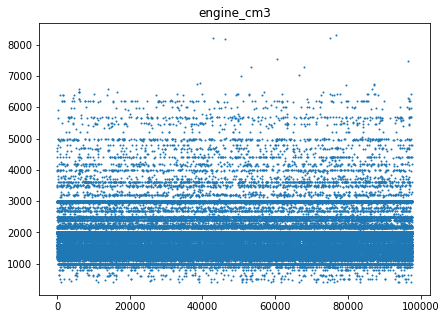

In [11]:
data.scatter_nox()

The scatter plots show data variables on y axis and have ID on the x axis. As we can see we have one car with mileage around 1*10^11 million kilometers and a few with price of more than PLN 5 million. Let's first discard cars with mileage greater than 2 million km.

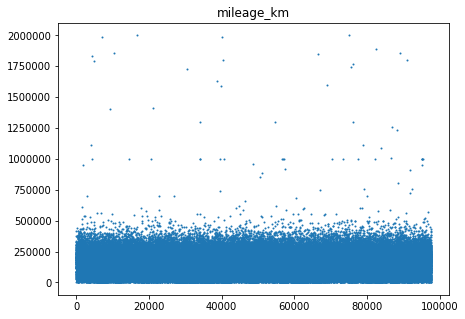

In [11]:
data.remove_outliers('mileage_km', 2000000, 'more_than')
data.scatter_nox('mileage_km')

Looks like there are still some car with extreme mileage. Let's discard cars with mileage greater than 400 thousand kilometers. Putting things into perspective, 400 thousand kilometers is a lot for the car and relatively unusual to see.

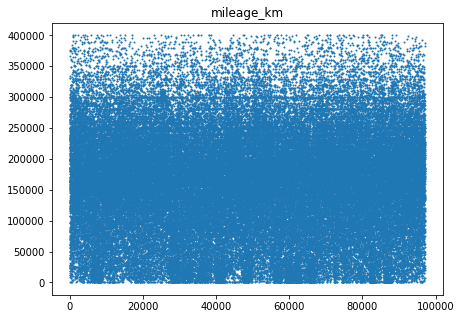

In [15]:
data.remove_outliers('mileage_km', 400000, 'more_than')
data.scatter_nox('mileage_km')

In [33]:
analysis = x.analyse_variables(corpus, discard = 0.01)

In [6]:
analysis = pd.read_csv('analyse_variables_results.csv', index_col=0)

In [7]:
variables = analysis['variable'].values.tolist()
cleaned_variables = an.CleanList(list_to_clean = variables, len_less_than = 3)

In [8]:
data.add_dummies2(cleaned_variables)

In [9]:
categories_engine_type = data.data['engine_type'].unique().tolist()

In [45]:
categories_engine_type

['Benzyna', 'Diesel', 'Benzyna+LPG', 'Hybryda', 'Benzyna+CNG', 'Elektryczny']

In [30]:
categories_engine_type = self.data['engine_type'].unique().tolist()
data.add_dummies(columns_to_check = ['engine_type'],  delete_column = 'yes')

In [12]:
categories_province = data.data['province'].unique().tolist()
categories_province

['slaskie',
 'mazowieckie',
 'lódzkie',
 'dolnoslaskie',
 'lubelskie',
 'malopolskie',
 'wielkopolskie',
 'warmińsko-mazurskie',
 'lubuskie',
 'kujawsko-pomorskie',
 'podlaskie',
 'podkarpackie',
 'pomorskie',
 'zachodniopomorskie',
 'opolskie',
 'swietokrzyskie',
 'region midtjylland',
 'zylina',
 'moravian-silesian region',
 'noord-brabant',
 'distrito de aveiro',
 'wilno',
 'noord-holland',
 'region hovestaden',
 'nordrhein-westfalen',
 'languedoc-roussillon-midi-pyrénées',
 'hessen',
 'berlin',
 'niedersachsen']

In [37]:
data.analyse_variabe

In [10]:
data.analyse_variables(list_of_variables = categories_engine_type, discard = 0, column_categorical = 'engine_type')

,variable,mean_1,mean_0,count_1,count_0,mean_diff
0,Hybryda,71467.168047,31488.839150,845,88772,39978.328898
1,Benzyna+LPG,17527.817405,32866.927490,5849,83768,15339.110086
2,Elektryczny,43445.000000,31865.536975,2,89615,11579.463025
3,Benzyna+CNG,23135.740741,31868.426398,27,89590,8732.685657
4,Diesel,33902.167144,30135.919554,41162,48455,3766.247590
5,Benzyna,31070.029378,32559.309178,41732,47885,1489.279800


In [13]:
data.analyse_variables(list_of_variables = categories_province, discard = 0,  column_categorical = 'province')

,variable,mean_1,mean_0,count_1,count_0,mean_diff
0,noord-holland,65000.000000,31865.425661,1,89616,33134.574339
1,noord-brabant,694.444444,31868.926167,9,89608,31174.481723
2,languedoc-roussillon-midi-pyrénées,4881.818182,31869.107939,11,89606,26987.289757
3,region hovestaden,5625.000000,31866.381030,2,89615,26241.381030
4,nordrhein-westfalen,7500.000000,31866.067287,1,89616,24366.067287
5,zylina,9200.000000,31866.048317,1,89616,22666.048317
6,niedersachsen,12500.000000,31866.011493,1,89616,19366.011493
7,region midtjylland,15000.000000,31865.983597,1,89616,16865.983597
8,wilno,15006.000000,31865.983530,1,89616,16859.983530
9,hessen,16999.000000,31865.961290,1,89616,14866.961290


In [31]:
categories_province = self.data['province'].unique().tolist()
data.add_dummies(columns_to_check = ['province'], delete_column = 'yes')

In [35]:
data.data

,ID,title,price,sub_title,mileage_km,year,engine_cm3,city,negotiable,concat_title_subtitle,alfa,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,dodge,fiat,ford,honda,hyundai,jaguar,jeep,kia,rover,lexus,mazda,mercedes,mitsubishi,nissan,opel,peugeot,porsche,renault,seat,smart,subaru,suzuki,tesla,toyota,volkswagen,volvo,skoda,drive,fv23,v23,20d,pakiet,akiet,pak,dsg,vat,quattro,quat,fort,line,for,akt,kam,amer,fak,led,lin,tsi,pre,salon,klimatyzacj,sal,ful,corsa,180,tyl,raw,polo,klima,klim,aso,tiv,ima,16v,elektr,gaz,drzw,drz,fabia,opłat,lim,50km,0td,sport,elekt,niemie,sprowadzon,spro,150k,asa,elek,wad,lpg,clio,niem,fiesta,fiest,dobry,ład,opł,201,200,4x4,polska,spr,alufelgi,zadbana,pano,benzyn,benzy,150,enzyna,alufelg,alufel,klas,sce,zadb,90km,ram,man,bdb,105,felgi,gwa,tec,citroën,felg,spo,focus,picasso,astra,megan,jak,pcja,astr,zarejestr,zarejest,zarej,yaris,krajowy,qashqai,qashqa,rejestrowany,reje,ora,jest,nav,iii,pic,kombi,mega,zar,opc,tronik,dam,con,polski,dti,bard,krajow,tom,alu,aut,seria,seri,ara,pan,rej,nie,hdi,str,szyb,kom,golf,przed,polecam,poleca,kraj,gol,nowy,ins,naw,sta,kóra,pierwszy,wszy,titanium,wers,wer,rav,peł,oryginal,pol,pier,fab,okazja,okaz,orygi,skó,oryg,tra,prz,grand,110,lift,wyp,000,super,sup,avant,diesel,diese,rok,lif,turb,dach,wła,pas,bezw,100,tron,idea,cic,tys,ser,tyś,tdci,dci,tour,tempo,tdc,osob,bieg,140,zamia,mały,cam,zam,oso,pryw,ory,bie,avensis,nic,monde,tel,xen,ben,enon,oro,cja,gran,mat,temp,crd,bog,sel,tdi,kod,40km,120,park,tem,130,pro,fote,tani,fot,pdc,grza,170,par,sat,octavia,octavi,max,van,sto,pod,cta,ass,ele,szy,bez,ani,nisk,grz,and,kier,engine_type_Benzyna,engine_type_Diesel,engine_type_Hybryda,engine_type_Elektryczny,province_slaskie,province_mazowieckie,province_lódzkie,province_lubelskie,province_malopolskie,province_wielkopolskie,province_warmińsko-mazurskie,province_lubuskie,province_kujawsko-pomorskie,province_podlaskie,province_podkarpackie,province_pomorskie,province_opolskie,province_swietokrzyskie,province_region midtjylland,province_zylina,province_moravian-silesian region,province_noord-brabant,province_wilno,province_noord-holland,province_region hovestaden,province_nordrhein-westfalen,province_languedoc-roussillon-midi-pyrénées,province_hessen,province_berlin,province_niedersachsen
0,1,Mazda CX-3,69700,150KM 6AT 4x4 SkyPASSION (+ Biala skóra + Safe...,51015.0,2015,1998,Katowice,nan,cx 3 1 6at skysion biala s safety i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Peugeot Partner,19500,Opłacony~Dokumentacja Przebiegu,180000.0,2009,1600,Garbatka-Letnisko,Do negocjacji,tner ay dokumenta eu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Kia Sportage,26800,Opłacona~Napęd 4x4,165000.0,2009,2000,Garbatka-Letnisko,Do negocjacji,age aa napęd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [4]:
date = datetime.date(datetime.now())
data.data.to_csv('data_'+str(date)+'.csv')

NameError: name 'data' is not defined

## Read Data

In [44]:
data = pd.read_csv('data_2020-06-29.csv', index_col = 0)

In [45]:
X = pd.concat([data.iloc[: , [4,5,6]], data.iloc[: , 10:]], axis = 1, sort = False)
y = data['price'].copy()

In [46]:
stand_scale = StandardScaler()
X_scaled = stand_scale.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2)

## Gradient Boosting

In [48]:
xgb = XGBRegressor(learning_rate = 0.08, objective = 'reg:squarederror', nthread =  8,
                  tree_method = 'gpu_hist', max_depth = 7, n_estimators = 1440,
                  booster = 'gbtree', verbosity = 2)

In [49]:
xgb.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae'
        )

[0]	validation_0-mae:29300.76562	validation_1-mae:28930.73047
[1]	validation_0-mae:26971.72656	validation_1-mae:26629.20703
[2]	validation_0-mae:24841.13086	validation_1-mae:24523.94922
[3]	validation_0-mae:22894.94922	validation_1-mae:22604.11328
[4]	validation_0-mae:21124.51953	validation_1-mae:20850.83594
[5]	validation_0-mae:19518.09375	validation_1-mae:19263.09961
[6]	validation_0-mae:18066.75391	validation_1-mae:17830.93164
[7]	validation_0-mae:16760.30273	validation_1-mae:16536.04688
[8]	validation_0-mae:15590.49609	validation_1-mae:15378.47656
[9]	validation_0-mae:14545.45215	validation_1-mae:14341.90234
[10]	validation_0-mae:13611.18652	validation_1-mae:13418.28809
[11]	validation_0-mae:12781.29004	validation_1-mae:12602.89258
[12]	validation_0-mae:12046.96484	validation_1-mae:11876.59961
[13]	validation_0-mae:11394.50293	validation_1-mae:11231.75000
[14]	validation_0-mae:10828.04102	validation_1-mae:10677.86719
[15]	validation_0-mae:10330.75879	validation_1-mae:10186.66113
[1

[134]	validation_0-mae:5959.29150	validation_1-mae:6398.73682
[135]	validation_0-mae:5953.14941	validation_1-mae:6393.83691
[136]	validation_0-mae:5950.10205	validation_1-mae:6392.18262
[137]	validation_0-mae:5943.44873	validation_1-mae:6388.35889
[138]	validation_0-mae:5938.97217	validation_1-mae:6385.84522
[139]	validation_0-mae:5934.33057	validation_1-mae:6382.28857
[140]	validation_0-mae:5928.68848	validation_1-mae:6378.22119
[141]	validation_0-mae:5924.62500	validation_1-mae:6374.71924
[142]	validation_0-mae:5920.89307	validation_1-mae:6372.74853
[143]	validation_0-mae:5915.41064	validation_1-mae:6368.94434
[144]	validation_0-mae:5912.68213	validation_1-mae:6367.24902
[145]	validation_0-mae:5908.30811	validation_1-mae:6365.91211
[146]	validation_0-mae:5903.45459	validation_1-mae:6363.41406
[147]	validation_0-mae:5897.27832	validation_1-mae:6360.96973
[148]	validation_0-mae:5894.40430	validation_1-mae:6359.74365
[149]	validation_0-mae:5889.88086	validation_1-mae:6358.31738
[150]	va

[267]	validation_0-mae:5488.18164	validation_1-mae:6172.56836
[268]	validation_0-mae:5484.96533	validation_1-mae:6171.30469
[269]	validation_0-mae:5482.27978	validation_1-mae:6171.19824
[270]	validation_0-mae:5478.57666	validation_1-mae:6169.16162
[271]	validation_0-mae:5475.53564	validation_1-mae:6169.08105
[272]	validation_0-mae:5472.17773	validation_1-mae:6168.49268
[273]	validation_0-mae:5469.80176	validation_1-mae:6167.28809
[274]	validation_0-mae:5466.73145	validation_1-mae:6166.59424
[275]	validation_0-mae:5464.78809	validation_1-mae:6166.24316
[276]	validation_0-mae:5462.30078	validation_1-mae:6165.63086
[277]	validation_0-mae:5459.81250	validation_1-mae:6165.31006
[278]	validation_0-mae:5458.03418	validation_1-mae:6165.16162
[279]	validation_0-mae:5453.96777	validation_1-mae:6161.45508
[280]	validation_0-mae:5448.93701	validation_1-mae:6157.72705
[281]	validation_0-mae:5447.34717	validation_1-mae:6157.08691
[282]	validation_0-mae:5443.01855	validation_1-mae:6155.31592
[283]	va

[400]	validation_0-mae:5197.75635	validation_1-mae:6079.42822
[401]	validation_0-mae:5191.84717	validation_1-mae:6075.88232
[402]	validation_0-mae:5190.08203	validation_1-mae:6075.00635
[403]	validation_0-mae:5188.84570	validation_1-mae:6074.97412
[404]	validation_0-mae:5186.99658	validation_1-mae:6074.57861
[405]	validation_0-mae:5186.57422	validation_1-mae:6074.44385
[406]	validation_0-mae:5183.73877	validation_1-mae:6073.57910
[407]	validation_0-mae:5178.35498	validation_1-mae:6071.51416
[408]	validation_0-mae:5176.99121	validation_1-mae:6071.34033
[409]	validation_0-mae:5172.96484	validation_1-mae:6068.52734
[410]	validation_0-mae:5171.54102	validation_1-mae:6068.24219
[411]	validation_0-mae:5170.53760	validation_1-mae:6067.76270
[412]	validation_0-mae:5169.09277	validation_1-mae:6067.25928
[413]	validation_0-mae:5165.91553	validation_1-mae:6066.48145
[414]	validation_0-mae:5164.99805	validation_1-mae:6066.81250
[415]	validation_0-mae:5163.40088	validation_1-mae:6066.95703
[416]	va

[533]	validation_0-mae:4937.46875	validation_1-mae:6010.31055
[534]	validation_0-mae:4935.54297	validation_1-mae:6009.79834
[535]	validation_0-mae:4933.95947	validation_1-mae:6010.01855
[536]	validation_0-mae:4930.91406	validation_1-mae:6009.36621
[537]	validation_0-mae:4929.30566	validation_1-mae:6009.77197
[538]	validation_0-mae:4927.09863	validation_1-mae:6008.58105
[539]	validation_0-mae:4925.09424	validation_1-mae:6007.30518
[540]	validation_0-mae:4924.56885	validation_1-mae:6006.94922
[541]	validation_0-mae:4923.46289	validation_1-mae:6007.05225
[542]	validation_0-mae:4919.98291	validation_1-mae:6005.22754
[543]	validation_0-mae:4917.66211	validation_1-mae:6005.50488
[544]	validation_0-mae:4915.67822	validation_1-mae:6004.85596
[545]	validation_0-mae:4915.00147	validation_1-mae:6004.63281
[546]	validation_0-mae:4913.85156	validation_1-mae:6004.77100
[547]	validation_0-mae:4912.59570	validation_1-mae:6005.46338
[548]	validation_0-mae:4911.68213	validation_1-mae:6005.52100
[549]	va

[666]	validation_0-mae:4738.00684	validation_1-mae:5975.42383
[667]	validation_0-mae:4737.19385	validation_1-mae:5975.09863
[668]	validation_0-mae:4735.33057	validation_1-mae:5974.26758
[669]	validation_0-mae:4733.10449	validation_1-mae:5974.16553
[670]	validation_0-mae:4731.39941	validation_1-mae:5974.08496
[671]	validation_0-mae:4728.92432	validation_1-mae:5974.69873
[672]	validation_0-mae:4727.78564	validation_1-mae:5974.01074
[673]	validation_0-mae:4726.87353	validation_1-mae:5974.20898
[674]	validation_0-mae:4725.99756	validation_1-mae:5973.81201
[675]	validation_0-mae:4725.65186	validation_1-mae:5973.86768
[676]	validation_0-mae:4724.44043	validation_1-mae:5973.85791
[677]	validation_0-mae:4723.88428	validation_1-mae:5974.23389
[678]	validation_0-mae:4722.66016	validation_1-mae:5973.98828
[679]	validation_0-mae:4721.44043	validation_1-mae:5973.61523
[680]	validation_0-mae:4720.78711	validation_1-mae:5973.60498
[681]	validation_0-mae:4720.54688	validation_1-mae:5973.64160
[682]	va

[799]	validation_0-mae:4558.33301	validation_1-mae:5955.89600
[800]	validation_0-mae:4556.54736	validation_1-mae:5955.79492
[801]	validation_0-mae:4554.11865	validation_1-mae:5955.79150
[802]	validation_0-mae:4552.88721	validation_1-mae:5955.84180
[803]	validation_0-mae:4552.29541	validation_1-mae:5955.51660
[804]	validation_0-mae:4550.89502	validation_1-mae:5955.30225
[805]	validation_0-mae:4548.41699	validation_1-mae:5955.49609
[806]	validation_0-mae:4547.34522	validation_1-mae:5955.41260
[807]	validation_0-mae:4545.26855	validation_1-mae:5955.31934
[808]	validation_0-mae:4544.11816	validation_1-mae:5955.17480
[809]	validation_0-mae:4541.98145	validation_1-mae:5954.91553
[810]	validation_0-mae:4540.90088	validation_1-mae:5954.80420
[811]	validation_0-mae:4540.82861	validation_1-mae:5954.82812
[812]	validation_0-mae:4539.83789	validation_1-mae:5955.14404
[813]	validation_0-mae:4539.07910	validation_1-mae:5954.92090
[814]	validation_0-mae:4537.80225	validation_1-mae:5955.04883
[815]	va

[932]	validation_0-mae:4378.62647	validation_1-mae:5940.72119
[933]	validation_0-mae:4378.35596	validation_1-mae:5940.54980
[934]	validation_0-mae:4378.32568	validation_1-mae:5940.60303
[935]	validation_0-mae:4376.55127	validation_1-mae:5941.12305
[936]	validation_0-mae:4375.82031	validation_1-mae:5941.60889
[937]	validation_0-mae:4374.51904	validation_1-mae:5941.54688
[938]	validation_0-mae:4372.96094	validation_1-mae:5941.78613
[939]	validation_0-mae:4371.60840	validation_1-mae:5941.58496
[940]	validation_0-mae:4369.17041	validation_1-mae:5941.41211
[941]	validation_0-mae:4368.48340	validation_1-mae:5941.39990
[942]	validation_0-mae:4367.38965	validation_1-mae:5941.55469
[943]	validation_0-mae:4365.05957	validation_1-mae:5942.20215
[944]	validation_0-mae:4364.45215	validation_1-mae:5942.10010
[945]	validation_0-mae:4361.98633	validation_1-mae:5941.96143
[946]	validation_0-mae:4361.29883	validation_1-mae:5941.93408
[947]	validation_0-mae:4359.73877	validation_1-mae:5941.57080
[948]	va

[1064]	validation_0-mae:4235.44580	validation_1-mae:5930.82129
[1065]	validation_0-mae:4233.42188	validation_1-mae:5930.57373
[1066]	validation_0-mae:4232.78272	validation_1-mae:5930.77978
[1067]	validation_0-mae:4231.63428	validation_1-mae:5930.66357
[1068]	validation_0-mae:4230.45166	validation_1-mae:5931.50244
[1069]	validation_0-mae:4230.00342	validation_1-mae:5931.59473
[1070]	validation_0-mae:4229.10693	validation_1-mae:5931.55322
[1071]	validation_0-mae:4228.54980	validation_1-mae:5931.48096
[1072]	validation_0-mae:4226.14258	validation_1-mae:5931.50732
[1073]	validation_0-mae:4225.32129	validation_1-mae:5931.64307
[1074]	validation_0-mae:4223.95068	validation_1-mae:5931.85156
[1075]	validation_0-mae:4223.25439	validation_1-mae:5931.75635
[1076]	validation_0-mae:4222.25342	validation_1-mae:5931.60254
[1077]	validation_0-mae:4221.34473	validation_1-mae:5931.79053
[1078]	validation_0-mae:4220.53613	validation_1-mae:5931.91895
[1079]	validation_0-mae:4219.99414	validation_1-mae:593

[1195]	validation_0-mae:4095.70557	validation_1-mae:5926.25000
[1196]	validation_0-mae:4094.93457	validation_1-mae:5925.76611
[1197]	validation_0-mae:4093.76880	validation_1-mae:5925.82617
[1198]	validation_0-mae:4092.84009	validation_1-mae:5925.68848
[1199]	validation_0-mae:4092.14624	validation_1-mae:5925.96338
[1200]	validation_0-mae:4091.18994	validation_1-mae:5926.06445
[1201]	validation_0-mae:4089.81323	validation_1-mae:5924.96143
[1202]	validation_0-mae:4088.59058	validation_1-mae:5925.41992
[1203]	validation_0-mae:4086.65991	validation_1-mae:5924.83105
[1204]	validation_0-mae:4085.03589	validation_1-mae:5924.77978
[1205]	validation_0-mae:4084.26587	validation_1-mae:5924.95898
[1206]	validation_0-mae:4083.64258	validation_1-mae:5924.73975
[1207]	validation_0-mae:4081.97046	validation_1-mae:5925.02930
[1208]	validation_0-mae:4081.31274	validation_1-mae:5924.97217
[1209]	validation_0-mae:4080.22632	validation_1-mae:5924.91504
[1210]	validation_0-mae:4078.88013	validation_1-mae:592

[1326]	validation_0-mae:3963.36890	validation_1-mae:5917.79004
[1327]	validation_0-mae:3961.92358	validation_1-mae:5917.41846
[1328]	validation_0-mae:3961.09912	validation_1-mae:5917.54395
[1329]	validation_0-mae:3960.22510	validation_1-mae:5917.22705
[1330]	validation_0-mae:3958.63062	validation_1-mae:5917.33203
[1331]	validation_0-mae:3957.83106	validation_1-mae:5917.41113
[1332]	validation_0-mae:3956.07788	validation_1-mae:5917.18945
[1333]	validation_0-mae:3954.62671	validation_1-mae:5916.83203
[1334]	validation_0-mae:3954.12061	validation_1-mae:5916.88721
[1335]	validation_0-mae:3953.44605	validation_1-mae:5917.01025
[1336]	validation_0-mae:3952.33106	validation_1-mae:5916.62744
[1337]	validation_0-mae:3951.52197	validation_1-mae:5916.87695
[1338]	validation_0-mae:3950.76514	validation_1-mae:5917.19922
[1339]	validation_0-mae:3949.72534	validation_1-mae:5917.34863
[1340]	validation_0-mae:3948.37061	validation_1-mae:5917.37744
[1341]	validation_0-mae:3947.52148	validation_1-mae:591

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1440, n_jobs=8, nthread=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=False, verbosity=2)

In [50]:
variable_importance = CombineTwoLists(X_train.columns.values.tolist(), xgb.feature_importances_.tolist())
variable_importance.sort(key = lambda x:x[1], reverse = True)

In [ ]:
for i in range(len(X_train.columns)):
        
    print('Dropping: '+str(a[len(X_train.columns)-i-1][0]))
    
    X_train = X_train.drop(columns = variable_importance[len(X_train.columns)-i-1][0])
    X_test = X_test.drop(columns = variable_importance[len(X_test.columns)-i-1][0])
    
    xgb1 = XGBRegressor(learning_rate = 0.1, objective = 'reg:squarederror', nthread =  8,
                  tree_method = 'gpu_hist', max_depth = 6, n_estimators = 1700,
                  booster = 'gbtree', verbosity = 2)
    
    xgb1.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae'
        )

In [51]:
variable_importance_selected = variable_importance[178:]

In [52]:
columns_to_drop = SplitList(variable_importance_selected)

In [53]:
X_train = X_train.drop(columns = columns_to_drop).copy()

In [54]:
X_test = X_test.drop(columns = columns_to_drop).copy()

In [55]:
X_train.to_csv('X_train_21-07-2020.csv')
X_test.to_csv('X_test_21-07-2020.csv')
pd.DataFrame(y_test).to_csv('y_test_21-07-2020.csv')
pd.DataFrame(y_train).to_csv('y_train_21-07-2020.csv')

### Read modified data

In [3]:
X_train = pd.read_csv('X_train_21-07-2020.csv', index_col = 0)
X_test = pd.read_csv('X_test_21-07-2020.csv', index_col = 0)
y_test = pd.read_csv('y_test_21-07-2020.csv', index_col = 0)
y_train = pd.read_csv('y_train_21-07-2020.csv', index_col = 0)

In [6]:
xgb = XGBRegressor(learning_rate = 0.02, objective = 'reg:squarederror', nthread =  8,
                  tree_method = 'gpu_hist', max_depth = 7, n_estimators = 4000,
                  booster = 'gbtree', verbosity = 2)

In [7]:
xgb.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae'
        )

[0]	validation_0-mae:31202.19141	validation_1-mae:30808.82812
[1]	validation_0-mae:30580.68945	validation_1-mae:30193.45703
[2]	validation_0-mae:29971.97852	validation_1-mae:29591.83008
[3]	validation_0-mae:29375.49219	validation_1-mae:29002.45312
[4]	validation_0-mae:28791.08789	validation_1-mae:28424.89844
[5]	validation_0-mae:28218.58203	validation_1-mae:27859.33984
[6]	validation_0-mae:27658.01367	validation_1-mae:27305.50781
[7]	validation_0-mae:27109.18750	validation_1-mae:26763.15625
[8]	validation_0-mae:26572.11328	validation_1-mae:26232.50586
[9]	validation_0-mae:26046.70312	validation_1-mae:25712.20117
[10]	validation_0-mae:25532.81641	validation_1-mae:25204.46680
[11]	validation_0-mae:25029.97266	validation_1-mae:24706.61133
[12]	validation_0-mae:24537.73828	validation_1-mae:24221.06250
[13]	validation_0-mae:24056.49609	validation_1-mae:23744.36914
[14]	validation_0-mae:23585.68945	validation_1-mae:23278.91992
[15]	validation_0-mae:23125.38477	validation_1-mae:22823.57227
[1

[132]	validation_0-mae:7274.96582	validation_1-mae:7311.39746
[133]	validation_0-mae:7259.85791	validation_1-mae:7299.13184
[134]	validation_0-mae:7245.92139	validation_1-mae:7288.07080
[135]	validation_0-mae:7232.05127	validation_1-mae:7276.53613
[136]	validation_0-mae:7218.44629	validation_1-mae:7264.57422
[137]	validation_0-mae:7205.35645	validation_1-mae:7254.76074
[138]	validation_0-mae:7191.71680	validation_1-mae:7243.07227
[139]	validation_0-mae:7179.92432	validation_1-mae:7234.13721
[140]	validation_0-mae:7168.02881	validation_1-mae:7224.11230
[141]	validation_0-mae:7155.85449	validation_1-mae:7213.60889
[142]	validation_0-mae:7145.56397	validation_1-mae:7205.31836
[143]	validation_0-mae:7134.72314	validation_1-mae:7196.61377
[144]	validation_0-mae:7124.95117	validation_1-mae:7189.15137
[145]	validation_0-mae:7113.94287	validation_1-mae:7179.77783
[146]	validation_0-mae:7102.84131	validation_1-mae:7170.91943
[147]	validation_0-mae:7092.12451	validation_1-mae:7162.51758
[148]	va

[265]	validation_0-mae:6506.25781	validation_1-mae:6749.76611
[266]	validation_0-mae:6504.19336	validation_1-mae:6748.50928
[267]	validation_0-mae:6500.79541	validation_1-mae:6745.85986
[268]	validation_0-mae:6496.94482	validation_1-mae:6742.93213
[269]	validation_0-mae:6494.63086	validation_1-mae:6741.53418
[270]	validation_0-mae:6491.99072	validation_1-mae:6740.00537
[271]	validation_0-mae:6488.49365	validation_1-mae:6737.39600
[272]	validation_0-mae:6485.39062	validation_1-mae:6735.95020
[273]	validation_0-mae:6482.19092	validation_1-mae:6733.89258
[274]	validation_0-mae:6480.17285	validation_1-mae:6732.48682
[275]	validation_0-mae:6477.02539	validation_1-mae:6730.46484
[276]	validation_0-mae:6473.77783	validation_1-mae:6728.82031
[277]	validation_0-mae:6470.98389	validation_1-mae:6726.57422
[278]	validation_0-mae:6468.72168	validation_1-mae:6725.61377
[279]	validation_0-mae:6464.81689	validation_1-mae:6722.73291
[280]	validation_0-mae:6461.67139	validation_1-mae:6720.84131
[281]	va

[398]	validation_0-mae:6192.07422	validation_1-mae:6542.47412
[399]	validation_0-mae:6191.03125	validation_1-mae:6542.22754
[400]	validation_0-mae:6189.11914	validation_1-mae:6541.02393
[401]	validation_0-mae:6187.20654	validation_1-mae:6540.18555
[402]	validation_0-mae:6185.14307	validation_1-mae:6539.29346
[403]	validation_0-mae:6183.27637	validation_1-mae:6537.79297
[404]	validation_0-mae:6182.07715	validation_1-mae:6537.01465
[405]	validation_0-mae:6181.13379	validation_1-mae:6536.17773
[406]	validation_0-mae:6179.08350	validation_1-mae:6534.76416
[407]	validation_0-mae:6177.85889	validation_1-mae:6534.31348
[408]	validation_0-mae:6176.17969	validation_1-mae:6533.36377
[409]	validation_0-mae:6174.47119	validation_1-mae:6532.30566
[410]	validation_0-mae:6172.30127	validation_1-mae:6530.62353
[411]	validation_0-mae:6171.41064	validation_1-mae:6529.96240
[412]	validation_0-mae:6170.12891	validation_1-mae:6529.36572
[413]	validation_0-mae:6169.03955	validation_1-mae:6528.80420
[414]	va

[531]	validation_0-mae:6006.66406	validation_1-mae:6430.98926
[532]	validation_0-mae:6005.49219	validation_1-mae:6430.57471
[533]	validation_0-mae:6005.01855	validation_1-mae:6430.41797
[534]	validation_0-mae:6004.38232	validation_1-mae:6430.15674
[535]	validation_0-mae:6003.19238	validation_1-mae:6429.36377
[536]	validation_0-mae:6001.52246	validation_1-mae:6428.52930
[537]	validation_0-mae:6000.77978	validation_1-mae:6427.89014
[538]	validation_0-mae:5999.56348	validation_1-mae:6427.08398
[539]	validation_0-mae:5997.75000	validation_1-mae:6426.02246
[540]	validation_0-mae:5996.68018	validation_1-mae:6425.35840
[541]	validation_0-mae:5995.42725	validation_1-mae:6424.25293
[542]	validation_0-mae:5994.24414	validation_1-mae:6423.51270
[543]	validation_0-mae:5992.10449	validation_1-mae:6422.33203
[544]	validation_0-mae:5991.13623	validation_1-mae:6421.95068
[545]	validation_0-mae:5990.50928	validation_1-mae:6421.52930
[546]	validation_0-mae:5989.65967	validation_1-mae:6420.95410
[547]	va

[664]	validation_0-mae:5856.70410	validation_1-mae:6355.42725
[665]	validation_0-mae:5855.09912	validation_1-mae:6354.30225
[666]	validation_0-mae:5853.62012	validation_1-mae:6353.27441
[667]	validation_0-mae:5852.94141	validation_1-mae:6352.97363
[668]	validation_0-mae:5851.71436	validation_1-mae:6352.55811
[669]	validation_0-mae:5851.35107	validation_1-mae:6352.36572
[670]	validation_0-mae:5850.01562	validation_1-mae:6351.88770
[671]	validation_0-mae:5849.34424	validation_1-mae:6351.58447
[672]	validation_0-mae:5848.19189	validation_1-mae:6351.23438
[673]	validation_0-mae:5847.57861	validation_1-mae:6350.76221
[674]	validation_0-mae:5846.55176	validation_1-mae:6350.44238
[675]	validation_0-mae:5845.13770	validation_1-mae:6349.53076
[676]	validation_0-mae:5843.81885	validation_1-mae:6348.40039
[677]	validation_0-mae:5843.07129	validation_1-mae:6348.10107
[678]	validation_0-mae:5842.11914	validation_1-mae:6347.75000
[679]	validation_0-mae:5841.60156	validation_1-mae:6347.47754
[680]	va

[797]	validation_0-mae:5731.10400	validation_1-mae:6302.49561
[798]	validation_0-mae:5730.16602	validation_1-mae:6302.00488
[799]	validation_0-mae:5728.61963	validation_1-mae:6301.12744
[800]	validation_0-mae:5727.41162	validation_1-mae:6300.71533
[801]	validation_0-mae:5726.90820	validation_1-mae:6300.53906
[802]	validation_0-mae:5726.41895	validation_1-mae:6300.45654
[803]	validation_0-mae:5725.19971	validation_1-mae:6299.46045
[804]	validation_0-mae:5724.15332	validation_1-mae:6298.96777
[805]	validation_0-mae:5723.48291	validation_1-mae:6298.76758
[806]	validation_0-mae:5722.81934	validation_1-mae:6298.75879
[807]	validation_0-mae:5722.24072	validation_1-mae:6298.52783
[808]	validation_0-mae:5721.73486	validation_1-mae:6298.33643
[809]	validation_0-mae:5720.95947	validation_1-mae:6298.01318
[810]	validation_0-mae:5719.46240	validation_1-mae:6297.84522
[811]	validation_0-mae:5719.24561	validation_1-mae:6297.72266
[812]	validation_0-mae:5718.55566	validation_1-mae:6297.51660
[813]	va

[930]	validation_0-mae:5624.61230	validation_1-mae:6258.99268
[931]	validation_0-mae:5624.04688	validation_1-mae:6258.95264
[932]	validation_0-mae:5622.65820	validation_1-mae:6258.11670
[933]	validation_0-mae:5621.71680	validation_1-mae:6257.98193
[934]	validation_0-mae:5621.41357	validation_1-mae:6258.05615
[935]	validation_0-mae:5621.09473	validation_1-mae:6258.02002
[936]	validation_0-mae:5620.39648	validation_1-mae:6257.72900
[937]	validation_0-mae:5619.91357	validation_1-mae:6257.84326
[938]	validation_0-mae:5619.14795	validation_1-mae:6257.59375
[939]	validation_0-mae:5618.48389	validation_1-mae:6257.66211
[940]	validation_0-mae:5618.18945	validation_1-mae:6257.66699
[941]	validation_0-mae:5617.58691	validation_1-mae:6257.37451
[942]	validation_0-mae:5616.38818	validation_1-mae:6256.76465
[943]	validation_0-mae:5615.45801	validation_1-mae:6256.48975
[944]	validation_0-mae:5614.80664	validation_1-mae:6256.51270
[945]	validation_0-mae:5613.71436	validation_1-mae:6255.70312
[946]	va

[1062]	validation_0-mae:5536.70850	validation_1-mae:6227.45605
[1063]	validation_0-mae:5535.69531	validation_1-mae:6226.86719
[1064]	validation_0-mae:5534.71875	validation_1-mae:6226.72656
[1065]	validation_0-mae:5533.80225	validation_1-mae:6226.06592
[1066]	validation_0-mae:5533.21289	validation_1-mae:6225.89990
[1067]	validation_0-mae:5532.77148	validation_1-mae:6225.75928
[1068]	validation_0-mae:5531.69824	validation_1-mae:6225.52148
[1069]	validation_0-mae:5531.21680	validation_1-mae:6225.37256
[1070]	validation_0-mae:5530.76465	validation_1-mae:6225.13525
[1071]	validation_0-mae:5529.81641	validation_1-mae:6224.84619
[1072]	validation_0-mae:5529.51807	validation_1-mae:6224.82959
[1073]	validation_0-mae:5528.91406	validation_1-mae:6224.82275
[1074]	validation_0-mae:5528.05957	validation_1-mae:6224.57422
[1075]	validation_0-mae:5527.22900	validation_1-mae:6224.03076
[1076]	validation_0-mae:5526.02002	validation_1-mae:6223.33838
[1077]	validation_0-mae:5525.52148	validation_1-mae:622

[1193]	validation_0-mae:5449.02002	validation_1-mae:6196.68115
[1194]	validation_0-mae:5448.01758	validation_1-mae:6196.37988
[1195]	validation_0-mae:5447.23535	validation_1-mae:6196.07568
[1196]	validation_0-mae:5446.53711	validation_1-mae:6195.98047
[1197]	validation_0-mae:5446.05957	validation_1-mae:6195.83496
[1198]	validation_0-mae:5445.22412	validation_1-mae:6195.72607
[1199]	validation_0-mae:5444.66553	validation_1-mae:6195.50781
[1200]	validation_0-mae:5444.01367	validation_1-mae:6195.22022
[1201]	validation_0-mae:5443.77100	validation_1-mae:6195.06689
[1202]	validation_0-mae:5443.55371	validation_1-mae:6195.08887
[1203]	validation_0-mae:5442.94287	validation_1-mae:6194.55908
[1204]	validation_0-mae:5442.55811	validation_1-mae:6194.44189
[1205]	validation_0-mae:5441.56592	validation_1-mae:6193.93115
[1206]	validation_0-mae:5441.12939	validation_1-mae:6193.99316
[1207]	validation_0-mae:5440.61133	validation_1-mae:6193.81445
[1208]	validation_0-mae:5439.96387	validation_1-mae:619

[1324]	validation_0-mae:5369.32080	validation_1-mae:6172.24951
[1325]	validation_0-mae:5368.37647	validation_1-mae:6171.66162
[1326]	validation_0-mae:5368.02832	validation_1-mae:6171.41650
[1327]	validation_0-mae:5367.74658	validation_1-mae:6171.46289
[1328]	validation_0-mae:5367.03760	validation_1-mae:6171.32178
[1329]	validation_0-mae:5366.49805	validation_1-mae:6171.00635
[1330]	validation_0-mae:5366.17871	validation_1-mae:6170.85840
[1331]	validation_0-mae:5365.59326	validation_1-mae:6170.72070
[1332]	validation_0-mae:5365.07568	validation_1-mae:6170.45801
[1333]	validation_0-mae:5364.53955	validation_1-mae:6170.48438
[1334]	validation_0-mae:5364.17383	validation_1-mae:6170.44727
[1335]	validation_0-mae:5363.87939	validation_1-mae:6170.48730
[1336]	validation_0-mae:5363.22266	validation_1-mae:6170.42383
[1337]	validation_0-mae:5362.80225	validation_1-mae:6170.19678
[1338]	validation_0-mae:5361.86572	validation_1-mae:6170.10596
[1339]	validation_0-mae:5361.28906	validation_1-mae:617

[1455]	validation_0-mae:5292.19189	validation_1-mae:6146.18848
[1456]	validation_0-mae:5291.66699	validation_1-mae:6145.88135
[1457]	validation_0-mae:5291.04834	validation_1-mae:6145.65137
[1458]	validation_0-mae:5290.51172	validation_1-mae:6145.69775
[1459]	validation_0-mae:5289.88086	validation_1-mae:6145.58008
[1460]	validation_0-mae:5289.39160	validation_1-mae:6145.42432
[1461]	validation_0-mae:5289.02930	validation_1-mae:6145.19727
[1462]	validation_0-mae:5288.72461	validation_1-mae:6145.18603
[1463]	validation_0-mae:5288.31152	validation_1-mae:6145.07178
[1464]	validation_0-mae:5287.43994	validation_1-mae:6144.89355
[1465]	validation_0-mae:5286.85596	validation_1-mae:6144.84228
[1466]	validation_0-mae:5285.61670	validation_1-mae:6144.18897
[1467]	validation_0-mae:5285.13525	validation_1-mae:6143.90088
[1468]	validation_0-mae:5284.34863	validation_1-mae:6143.49756
[1469]	validation_0-mae:5283.60107	validation_1-mae:6143.24561
[1470]	validation_0-mae:5283.27393	validation_1-mae:614

[1586]	validation_0-mae:5223.33984	validation_1-mae:6125.73291
[1587]	validation_0-mae:5222.90576	validation_1-mae:6125.49268
[1588]	validation_0-mae:5222.39062	validation_1-mae:6125.15723
[1589]	validation_0-mae:5222.24365	validation_1-mae:6125.22998
[1590]	validation_0-mae:5221.85938	validation_1-mae:6125.25049
[1591]	validation_0-mae:5221.53223	validation_1-mae:6125.20264
[1592]	validation_0-mae:5220.99805	validation_1-mae:6124.97949
[1593]	validation_0-mae:5220.49023	validation_1-mae:6124.72998
[1594]	validation_0-mae:5220.13623	validation_1-mae:6124.62647
[1595]	validation_0-mae:5219.56006	validation_1-mae:6124.44043
[1596]	validation_0-mae:5219.16895	validation_1-mae:6124.24707
[1597]	validation_0-mae:5218.83643	validation_1-mae:6124.09424
[1598]	validation_0-mae:5218.40088	validation_1-mae:6123.99805
[1599]	validation_0-mae:5218.07422	validation_1-mae:6123.83252
[1600]	validation_0-mae:5217.51709	validation_1-mae:6123.64600
[1601]	validation_0-mae:5216.83350	validation_1-mae:612

[1717]	validation_0-mae:5156.39062	validation_1-mae:6106.36475
[1718]	validation_0-mae:5155.79785	validation_1-mae:6106.31103
[1719]	validation_0-mae:5155.34570	validation_1-mae:6106.10059
[1720]	validation_0-mae:5155.06250	validation_1-mae:6106.08105
[1721]	validation_0-mae:5154.57812	validation_1-mae:6105.85742
[1722]	validation_0-mae:5154.14014	validation_1-mae:6105.86279
[1723]	validation_0-mae:5153.88086	validation_1-mae:6105.89014
[1724]	validation_0-mae:5153.31152	validation_1-mae:6105.87012
[1725]	validation_0-mae:5152.77393	validation_1-mae:6105.86133
[1726]	validation_0-mae:5152.13379	validation_1-mae:6105.68994
[1727]	validation_0-mae:5151.79541	validation_1-mae:6105.62891
[1728]	validation_0-mae:5151.07568	validation_1-mae:6105.56885
[1729]	validation_0-mae:5150.86670	validation_1-mae:6105.50635
[1730]	validation_0-mae:5150.09131	validation_1-mae:6105.58105
[1731]	validation_0-mae:5149.88721	validation_1-mae:6105.58252
[1732]	validation_0-mae:5149.13818	validation_1-mae:610

[1848]	validation_0-mae:5087.31250	validation_1-mae:6090.52588
[1849]	validation_0-mae:5087.11523	validation_1-mae:6090.43506
[1850]	validation_0-mae:5086.65381	validation_1-mae:6090.35645
[1851]	validation_0-mae:5086.20557	validation_1-mae:6090.26709
[1852]	validation_0-mae:5085.29736	validation_1-mae:6090.14746
[1853]	validation_0-mae:5084.56641	validation_1-mae:6090.28027
[1854]	validation_0-mae:5084.16211	validation_1-mae:6090.40430
[1855]	validation_0-mae:5083.84180	validation_1-mae:6090.47217
[1856]	validation_0-mae:5083.47656	validation_1-mae:6090.26514
[1857]	validation_0-mae:5083.01953	validation_1-mae:6090.23730
[1858]	validation_0-mae:5082.76953	validation_1-mae:6090.18311
[1859]	validation_0-mae:5082.31738	validation_1-mae:6090.05566
[1860]	validation_0-mae:5081.88818	validation_1-mae:6089.98389
[1861]	validation_0-mae:5081.46826	validation_1-mae:6090.02051
[1862]	validation_0-mae:5080.97363	validation_1-mae:6089.92578
[1863]	validation_0-mae:5080.66357	validation_1-mae:608

[1979]	validation_0-mae:5017.36621	validation_1-mae:6077.57373
[1980]	validation_0-mae:5016.70264	validation_1-mae:6077.46094
[1981]	validation_0-mae:5016.34619	validation_1-mae:6077.55127
[1982]	validation_0-mae:5016.04980	validation_1-mae:6077.50732
[1983]	validation_0-mae:5015.76562	validation_1-mae:6077.49902
[1984]	validation_0-mae:5015.27441	validation_1-mae:6077.49512
[1985]	validation_0-mae:5014.98730	validation_1-mae:6077.32812
[1986]	validation_0-mae:5014.57568	validation_1-mae:6077.17383
[1987]	validation_0-mae:5013.96387	validation_1-mae:6077.27246
[1988]	validation_0-mae:5013.20654	validation_1-mae:6076.97412
[1989]	validation_0-mae:5012.84082	validation_1-mae:6076.95947
[1990]	validation_0-mae:5012.40723	validation_1-mae:6076.87744
[1991]	validation_0-mae:5011.65674	validation_1-mae:6076.68213
[1992]	validation_0-mae:5011.25147	validation_1-mae:6076.65820
[1993]	validation_0-mae:5011.11963	validation_1-mae:6076.68262
[1994]	validation_0-mae:5010.34766	validation_1-mae:607

[2110]	validation_0-mae:4954.63477	validation_1-mae:6068.27197
[2111]	validation_0-mae:4954.56836	validation_1-mae:6068.27441
[2112]	validation_0-mae:4953.80371	validation_1-mae:6068.30029
[2113]	validation_0-mae:4953.52441	validation_1-mae:6068.29102
[2114]	validation_0-mae:4953.17432	validation_1-mae:6068.14111
[2115]	validation_0-mae:4952.72852	validation_1-mae:6068.17725
[2116]	validation_0-mae:4951.96387	validation_1-mae:6067.70410
[2117]	validation_0-mae:4951.58691	validation_1-mae:6067.59766
[2118]	validation_0-mae:4951.28125	validation_1-mae:6067.64600
[2119]	validation_0-mae:4950.71728	validation_1-mae:6067.64062
[2120]	validation_0-mae:4950.39795	validation_1-mae:6067.62744
[2121]	validation_0-mae:4949.98682	validation_1-mae:6067.60352
[2122]	validation_0-mae:4949.68213	validation_1-mae:6067.63184
[2123]	validation_0-mae:4949.34912	validation_1-mae:6067.53467
[2124]	validation_0-mae:4949.08740	validation_1-mae:6067.54932
[2125]	validation_0-mae:4948.80469	validation_1-mae:606

[2241]	validation_0-mae:4897.83057	validation_1-mae:6060.27246
[2242]	validation_0-mae:4897.54688	validation_1-mae:6060.16846
[2243]	validation_0-mae:4897.19629	validation_1-mae:6060.10840
[2244]	validation_0-mae:4896.95410	validation_1-mae:6060.16455
[2245]	validation_0-mae:4896.40723	validation_1-mae:6059.96533
[2246]	validation_0-mae:4896.12012	validation_1-mae:6060.03516
[2247]	validation_0-mae:4895.52393	validation_1-mae:6059.88477
[2248]	validation_0-mae:4894.97266	validation_1-mae:6059.57568
[2249]	validation_0-mae:4894.73047	validation_1-mae:6059.56836
[2250]	validation_0-mae:4894.25098	validation_1-mae:6059.23242
[2251]	validation_0-mae:4893.45410	validation_1-mae:6058.97119
[2252]	validation_0-mae:4893.05029	validation_1-mae:6058.99853
[2253]	validation_0-mae:4892.73145	validation_1-mae:6059.00391
[2254]	validation_0-mae:4892.26367	validation_1-mae:6059.01318
[2255]	validation_0-mae:4891.98584	validation_1-mae:6059.11133
[2256]	validation_0-mae:4891.46875	validation_1-mae:605

[2372]	validation_0-mae:4837.72314	validation_1-mae:6049.22070
[2373]	validation_0-mae:4837.05713	validation_1-mae:6049.27637
[2374]	validation_0-mae:4836.48145	validation_1-mae:6049.06348
[2375]	validation_0-mae:4835.93311	validation_1-mae:6049.00293
[2376]	validation_0-mae:4835.42529	validation_1-mae:6048.89453
[2377]	validation_0-mae:4834.92041	validation_1-mae:6048.79834
[2378]	validation_0-mae:4834.70459	validation_1-mae:6048.72656
[2379]	validation_0-mae:4834.43603	validation_1-mae:6048.76318
[2380]	validation_0-mae:4834.01562	validation_1-mae:6048.83789
[2381]	validation_0-mae:4833.61621	validation_1-mae:6048.89209
[2382]	validation_0-mae:4833.25781	validation_1-mae:6049.04834
[2383]	validation_0-mae:4833.03369	validation_1-mae:6049.02783
[2384]	validation_0-mae:4832.54932	validation_1-mae:6048.96484
[2385]	validation_0-mae:4832.01904	validation_1-mae:6048.77978
[2386]	validation_0-mae:4831.70020	validation_1-mae:6048.95605
[2387]	validation_0-mae:4831.05664	validation_1-mae:604

[2503]	validation_0-mae:4784.57959	validation_1-mae:6041.42480
[2504]	validation_0-mae:4784.03272	validation_1-mae:6041.01416
[2505]	validation_0-mae:4783.50293	validation_1-mae:6041.04688
[2506]	validation_0-mae:4782.85400	validation_1-mae:6040.97754
[2507]	validation_0-mae:4782.72070	validation_1-mae:6040.88770
[2508]	validation_0-mae:4782.42236	validation_1-mae:6040.83203
[2509]	validation_0-mae:4781.73633	validation_1-mae:6040.80615
[2510]	validation_0-mae:4781.29346	validation_1-mae:6040.73291
[2511]	validation_0-mae:4780.81006	validation_1-mae:6040.65088
[2512]	validation_0-mae:4780.33984	validation_1-mae:6040.66162
[2513]	validation_0-mae:4779.74365	validation_1-mae:6040.72070
[2514]	validation_0-mae:4779.16309	validation_1-mae:6040.76660
[2515]	validation_0-mae:4778.74219	validation_1-mae:6040.59131
[2516]	validation_0-mae:4778.19775	validation_1-mae:6040.51953
[2517]	validation_0-mae:4777.69092	validation_1-mae:6040.49707
[2518]	validation_0-mae:4777.30615	validation_1-mae:604

[2634]	validation_0-mae:4725.89941	validation_1-mae:6031.16895
[2635]	validation_0-mae:4725.57031	validation_1-mae:6031.29150
[2636]	validation_0-mae:4725.30127	validation_1-mae:6031.22607
[2637]	validation_0-mae:4724.70020	validation_1-mae:6030.99902
[2638]	validation_0-mae:4724.24121	validation_1-mae:6030.83350
[2639]	validation_0-mae:4723.93750	validation_1-mae:6030.88379
[2640]	validation_0-mae:4723.45654	validation_1-mae:6030.95703
[2641]	validation_0-mae:4723.31982	validation_1-mae:6030.99463
[2642]	validation_0-mae:4722.96924	validation_1-mae:6031.09619
[2643]	validation_0-mae:4722.65283	validation_1-mae:6030.97559
[2644]	validation_0-mae:4722.28418	validation_1-mae:6030.97510
[2645]	validation_0-mae:4722.14355	validation_1-mae:6030.90869
[2646]	validation_0-mae:4722.00293	validation_1-mae:6030.92969
[2647]	validation_0-mae:4721.61328	validation_1-mae:6030.84473
[2648]	validation_0-mae:4721.34961	validation_1-mae:6030.76465
[2649]	validation_0-mae:4720.95215	validation_1-mae:603

[2765]	validation_0-mae:4675.06055	validation_1-mae:6022.71924
[2766]	validation_0-mae:4674.65381	validation_1-mae:6022.73682
[2767]	validation_0-mae:4674.18750	validation_1-mae:6022.65332
[2768]	validation_0-mae:4673.86230	validation_1-mae:6022.75244
[2769]	validation_0-mae:4673.55518	validation_1-mae:6022.82471
[2770]	validation_0-mae:4672.99365	validation_1-mae:6022.58643
[2771]	validation_0-mae:4672.50488	validation_1-mae:6022.45312
[2772]	validation_0-mae:4672.08838	validation_1-mae:6022.41260
[2773]	validation_0-mae:4671.81836	validation_1-mae:6022.42041
[2774]	validation_0-mae:4671.51074	validation_1-mae:6022.38379
[2775]	validation_0-mae:4671.14697	validation_1-mae:6022.28857
[2776]	validation_0-mae:4670.96875	validation_1-mae:6022.35107
[2777]	validation_0-mae:4670.50049	validation_1-mae:6022.30078
[2778]	validation_0-mae:4670.11133	validation_1-mae:6022.51270
[2779]	validation_0-mae:4669.49121	validation_1-mae:6022.40478
[2780]	validation_0-mae:4669.23926	validation_1-mae:602

[2896]	validation_0-mae:4619.27734	validation_1-mae:6014.86084
[2897]	validation_0-mae:4619.06152	validation_1-mae:6014.93897
[2898]	validation_0-mae:4618.66064	validation_1-mae:6014.92383
[2899]	validation_0-mae:4618.13525	validation_1-mae:6014.74023
[2900]	validation_0-mae:4617.72510	validation_1-mae:6014.53711
[2901]	validation_0-mae:4617.22070	validation_1-mae:6014.49219
[2902]	validation_0-mae:4616.73340	validation_1-mae:6014.32959
[2903]	validation_0-mae:4616.48389	validation_1-mae:6014.45459
[2904]	validation_0-mae:4616.09424	validation_1-mae:6014.34961
[2905]	validation_0-mae:4615.55859	validation_1-mae:6014.42285
[2906]	validation_0-mae:4615.30029	validation_1-mae:6014.42969
[2907]	validation_0-mae:4615.13379	validation_1-mae:6014.43115
[2908]	validation_0-mae:4614.65088	validation_1-mae:6014.26953
[2909]	validation_0-mae:4614.22559	validation_1-mae:6014.24609
[2910]	validation_0-mae:4613.99707	validation_1-mae:6014.33838
[2911]	validation_0-mae:4613.74463	validation_1-mae:601

[3027]	validation_0-mae:4569.85352	validation_1-mae:6008.06543
[3028]	validation_0-mae:4569.02686	validation_1-mae:6008.29297
[3029]	validation_0-mae:4568.61523	validation_1-mae:6008.06152
[3030]	validation_0-mae:4567.90332	validation_1-mae:6008.07471
[3031]	validation_0-mae:4567.57031	validation_1-mae:6007.84668
[3032]	validation_0-mae:4567.32812	validation_1-mae:6007.84766
[3033]	validation_0-mae:4566.93213	validation_1-mae:6007.72363
[3034]	validation_0-mae:4566.65967	validation_1-mae:6007.63916
[3035]	validation_0-mae:4566.38867	validation_1-mae:6007.49805
[3036]	validation_0-mae:4566.10596	validation_1-mae:6007.41504
[3037]	validation_0-mae:4565.87305	validation_1-mae:6007.41260
[3038]	validation_0-mae:4565.61426	validation_1-mae:6007.34570
[3039]	validation_0-mae:4565.32959	validation_1-mae:6007.33447
[3040]	validation_0-mae:4564.99951	validation_1-mae:6007.39746
[3041]	validation_0-mae:4564.90234	validation_1-mae:6007.44043
[3042]	validation_0-mae:4564.49609	validation_1-mae:600

[3158]	validation_0-mae:4525.87012	validation_1-mae:6002.96533
[3159]	validation_0-mae:4525.47900	validation_1-mae:6002.98877
[3160]	validation_0-mae:4525.17822	validation_1-mae:6002.88037
[3161]	validation_0-mae:4524.62891	validation_1-mae:6002.80029
[3162]	validation_0-mae:4524.45410	validation_1-mae:6002.81689
[3163]	validation_0-mae:4524.15234	validation_1-mae:6002.89844
[3164]	validation_0-mae:4523.88428	validation_1-mae:6002.82910
[3165]	validation_0-mae:4523.78125	validation_1-mae:6002.80127
[3166]	validation_0-mae:4523.57080	validation_1-mae:6002.77295
[3167]	validation_0-mae:4523.30371	validation_1-mae:6002.74219
[3168]	validation_0-mae:4523.05029	validation_1-mae:6002.74023
[3169]	validation_0-mae:4522.90088	validation_1-mae:6002.74170
[3170]	validation_0-mae:4522.74170	validation_1-mae:6002.74805
[3171]	validation_0-mae:4522.44385	validation_1-mae:6002.69385
[3172]	validation_0-mae:4522.08398	validation_1-mae:6002.76855
[3173]	validation_0-mae:4521.79785	validation_1-mae:600

[3289]	validation_0-mae:4486.38477	validation_1-mae:6000.74121
[3290]	validation_0-mae:4486.13477	validation_1-mae:6000.69727
[3291]	validation_0-mae:4486.04834	validation_1-mae:6000.68066
[3292]	validation_0-mae:4485.60449	validation_1-mae:6000.59570
[3293]	validation_0-mae:4485.44336	validation_1-mae:6000.51953
[3294]	validation_0-mae:4485.29688	validation_1-mae:6000.46094
[3295]	validation_0-mae:4484.94678	validation_1-mae:6000.34522
[3296]	validation_0-mae:4484.58594	validation_1-mae:6000.47070
[3297]	validation_0-mae:4484.29541	validation_1-mae:6000.40723
[3298]	validation_0-mae:4484.21973	validation_1-mae:6000.43994
[3299]	validation_0-mae:4483.89209	validation_1-mae:6000.49561
[3300]	validation_0-mae:4483.31152	validation_1-mae:6000.38770
[3301]	validation_0-mae:4483.00537	validation_1-mae:6000.34619
[3302]	validation_0-mae:4482.69434	validation_1-mae:6000.28516
[3303]	validation_0-mae:4482.38770	validation_1-mae:6000.31738
[3304]	validation_0-mae:4481.75586	validation_1-mae:600

[3420]	validation_0-mae:4437.95410	validation_1-mae:5997.19775
[3421]	validation_0-mae:4437.53320	validation_1-mae:5997.10059
[3422]	validation_0-mae:4437.19824	validation_1-mae:5996.98340
[3423]	validation_0-mae:4436.98340	validation_1-mae:5996.99463
[3424]	validation_0-mae:4436.30078	validation_1-mae:5997.01367
[3425]	validation_0-mae:4435.93408	validation_1-mae:5996.97900
[3426]	validation_0-mae:4435.65869	validation_1-mae:5997.01025
[3427]	validation_0-mae:4435.19531	validation_1-mae:5996.81250
[3428]	validation_0-mae:4434.87158	validation_1-mae:5996.92529
[3429]	validation_0-mae:4434.35498	validation_1-mae:5996.57861
[3430]	validation_0-mae:4434.11182	validation_1-mae:5996.65625
[3431]	validation_0-mae:4433.61523	validation_1-mae:5996.55469
[3432]	validation_0-mae:4433.23682	validation_1-mae:5996.39600
[3433]	validation_0-mae:4433.01611	validation_1-mae:5996.37891
[3434]	validation_0-mae:4432.57080	validation_1-mae:5996.08154
[3435]	validation_0-mae:4432.35107	validation_1-mae:599

[3551]	validation_0-mae:4393.45508	validation_1-mae:5993.80615
[3552]	validation_0-mae:4393.22119	validation_1-mae:5993.76416
[3553]	validation_0-mae:4392.96143	validation_1-mae:5993.75586
[3554]	validation_0-mae:4392.71582	validation_1-mae:5993.82666
[3555]	validation_0-mae:4392.57471	validation_1-mae:5993.83789
[3556]	validation_0-mae:4392.36084	validation_1-mae:5993.95996
[3557]	validation_0-mae:4391.88184	validation_1-mae:5993.86523
[3558]	validation_0-mae:4391.47217	validation_1-mae:5993.89746
[3559]	validation_0-mae:4391.22900	validation_1-mae:5993.82129
[3560]	validation_0-mae:4391.00439	validation_1-mae:5993.73682
[3561]	validation_0-mae:4390.79150	validation_1-mae:5993.67871
[3562]	validation_0-mae:4390.65527	validation_1-mae:5993.81201
[3563]	validation_0-mae:4390.24902	validation_1-mae:5993.72852
[3564]	validation_0-mae:4390.14209	validation_1-mae:5993.78125
[3565]	validation_0-mae:4389.81006	validation_1-mae:5993.75488
[3566]	validation_0-mae:4389.70557	validation_1-mae:599

[3682]	validation_0-mae:4353.14746	validation_1-mae:5990.99756
[3683]	validation_0-mae:4352.94482	validation_1-mae:5991.00439
[3684]	validation_0-mae:4352.59863	validation_1-mae:5990.90088
[3685]	validation_0-mae:4352.34912	validation_1-mae:5991.00488
[3686]	validation_0-mae:4351.92383	validation_1-mae:5991.02637
[3687]	validation_0-mae:4351.75293	validation_1-mae:5990.99805
[3688]	validation_0-mae:4351.47852	validation_1-mae:5990.94873
[3689]	validation_0-mae:4351.15137	validation_1-mae:5990.84522
[3690]	validation_0-mae:4350.84326	validation_1-mae:5990.81152
[3691]	validation_0-mae:4350.42920	validation_1-mae:5990.84180
[3692]	validation_0-mae:4350.05078	validation_1-mae:5990.85547
[3693]	validation_0-mae:4349.65186	validation_1-mae:5990.72266
[3694]	validation_0-mae:4349.22803	validation_1-mae:5990.69824
[3695]	validation_0-mae:4349.03418	validation_1-mae:5990.72363
[3696]	validation_0-mae:4348.43311	validation_1-mae:5990.69385
[3697]	validation_0-mae:4348.24463	validation_1-mae:599

[3813]	validation_0-mae:4311.05322	validation_1-mae:5988.60400
[3814]	validation_0-mae:4310.77393	validation_1-mae:5988.61963
[3815]	validation_0-mae:4310.42090	validation_1-mae:5988.58740
[3816]	validation_0-mae:4310.15186	validation_1-mae:5988.64111
[3817]	validation_0-mae:4309.83203	validation_1-mae:5988.68799
[3818]	validation_0-mae:4309.50635	validation_1-mae:5988.66992
[3819]	validation_0-mae:4309.18848	validation_1-mae:5988.67285
[3820]	validation_0-mae:4308.80225	validation_1-mae:5988.66602
[3821]	validation_0-mae:4308.46338	validation_1-mae:5988.78369
[3822]	validation_0-mae:4308.03613	validation_1-mae:5988.73779
[3823]	validation_0-mae:4307.66016	validation_1-mae:5988.56250
[3824]	validation_0-mae:4307.36670	validation_1-mae:5988.68066
[3825]	validation_0-mae:4307.16650	validation_1-mae:5988.71875
[3826]	validation_0-mae:4306.83936	validation_1-mae:5988.70752
[3827]	validation_0-mae:4306.28857	validation_1-mae:5988.64551
[3828]	validation_0-mae:4306.17725	validation_1-mae:598

[3944]	validation_0-mae:4267.61230	validation_1-mae:5985.70752
[3945]	validation_0-mae:4267.46533	validation_1-mae:5985.73193
[3946]	validation_0-mae:4267.34082	validation_1-mae:5985.67920
[3947]	validation_0-mae:4267.20605	validation_1-mae:5985.76074
[3948]	validation_0-mae:4266.86475	validation_1-mae:5985.87402
[3949]	validation_0-mae:4266.73926	validation_1-mae:5985.88867
[3950]	validation_0-mae:4266.60205	validation_1-mae:5985.89990
[3951]	validation_0-mae:4266.46826	validation_1-mae:5985.95215
[3952]	validation_0-mae:4266.33594	validation_1-mae:5985.96338
[3953]	validation_0-mae:4266.01904	validation_1-mae:5986.07178
[3954]	validation_0-mae:4265.75732	validation_1-mae:5986.07910
[3955]	validation_0-mae:4265.67480	validation_1-mae:5986.09814
[3956]	validation_0-mae:4265.52441	validation_1-mae:5986.11768
[3957]	validation_0-mae:4265.22461	validation_1-mae:5986.16699
[3958]	validation_0-mae:4264.98926	validation_1-mae:5986.25684
[3959]	validation_0-mae:4264.90772	validation_1-mae:598

[4075]	validation_0-mae:4231.96973	validation_1-mae:5984.89502
[4076]	validation_0-mae:4231.87402	validation_1-mae:5984.87061
[4077]	validation_0-mae:4231.36719	validation_1-mae:5984.71338
[4078]	validation_0-mae:4231.05957	validation_1-mae:5984.67627
[4079]	validation_0-mae:4230.52832	validation_1-mae:5984.37305
[4080]	validation_0-mae:4230.02246	validation_1-mae:5984.25781
[4081]	validation_0-mae:4229.84863	validation_1-mae:5984.28613
[4082]	validation_0-mae:4229.54980	validation_1-mae:5984.34912
[4083]	validation_0-mae:4229.37207	validation_1-mae:5984.47119
[4084]	validation_0-mae:4228.87891	validation_1-mae:5984.51807
[4085]	validation_0-mae:4228.38916	validation_1-mae:5984.62647
[4086]	validation_0-mae:4228.31787	validation_1-mae:5984.64551
[4087]	validation_0-mae:4227.92822	validation_1-mae:5984.53174
[4088]	validation_0-mae:4227.73047	validation_1-mae:5984.63135
[4089]	validation_0-mae:4227.44238	validation_1-mae:5984.58398
[4090]	validation_0-mae:4227.14648	validation_1-mae:598

[4206]	validation_0-mae:4192.41455	validation_1-mae:5986.63232
[4207]	validation_0-mae:4192.19922	validation_1-mae:5986.59912
[4208]	validation_0-mae:4191.76074	validation_1-mae:5986.87598
[4209]	validation_0-mae:4191.60791	validation_1-mae:5986.86328
[4210]	validation_0-mae:4191.42529	validation_1-mae:5986.83447
[4211]	validation_0-mae:4191.21777	validation_1-mae:5986.85156
[4212]	validation_0-mae:4190.89453	validation_1-mae:5986.84180
[4213]	validation_0-mae:4190.30078	validation_1-mae:5986.78223
[4214]	validation_0-mae:4190.11621	validation_1-mae:5986.76367
[4215]	validation_0-mae:4189.89062	validation_1-mae:5986.87012
[4216]	validation_0-mae:4189.62647	validation_1-mae:5987.03857
[4217]	validation_0-mae:4189.09570	validation_1-mae:5986.99902
[4218]	validation_0-mae:4188.71582	validation_1-mae:5987.16553
[4219]	validation_0-mae:4188.29199	validation_1-mae:5987.15674
[4220]	validation_0-mae:4188.02637	validation_1-mae:5987.16016
[4221]	validation_0-mae:4187.62305	validation_1-mae:598

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.02, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=4300, n_jobs=8, nthread=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=False, verbosity=2)

In [10]:
variable_importance = CombineTwoLists(X_train.columns.values.tolist(), xgb.feature_importances_.tolist())
variable_importance.sort(key = lambda x:x[1], reverse = True)

In [11]:
variable_importance

[['year', 0.09198532998561859],
 ['mercedes', 0.038929831236600876],
 ['engine_cm3', 0.033718355000019073],
 ['porsche', 0.025930358096957207],
 ['qashqai', 0.02010156959295273],
 ['audi', 0.019750265404582024],
 ['engine_type_Diesel', 0.019430553540587425],
 ['mazda', 0.018977157771587372],
 ['ford', 0.018717732280492783],
 ['bmw', 0.017929086461663246],
 ['corsa', 0.017317092046141624],
 ['ins', 0.017191678285598755],
 ['rover', 0.017187824472784996],
 ['dodge', 0.016814233735203743],
 ['drive', 0.014788992702960968],
 ['volvo', 0.014528068713843822],
 ['dacia', 0.014001532457768917],
 ['lexus', 0.012033816426992416],
 ['engine_type_Benzyna', 0.01136526558548212],
 ['20d', 0.010175839997828007],
 ['honda', 0.009373163804411888],
 ['chrysler', 0.008429037407040596],
 ['octavia', 0.00718411710113287],
 ['opel', 0.007116406224668026],
 ['chevrolet', 0.006882152985781431],
 ['clio', 0.006837648339569569],
 ['seria', 0.0066754864528775215],
 ['201', 0.006650283932685852],
 ['dsg', 0.00650

In [3]:
st.write("SOMETHING")